# Dimensionsreduzierung

In [246]:
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded

columns_encoded = columns_encoded
columns = columns
data = data
data_encoded = data_encoded

In [247]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

## Feature Selection

- Die Freitextfelder (d. h. "Lieblingssportart", "Lieblingsessen" & "Lieblings-Musiker*in") werden für die Dimensionsreduzierung entfernt
- Das neue Feature "Genre" bleibt hingegegen als One-Hot-Encoding bestehen, weil es hier einige Schnittmengen zwischen verschiedenen Datenpunkten gibt
- Begründungen
    - Durch die Umwandlung in numerische Werte per One-Hot-Encoding könnten diese theoretisch für Berechnung genutzt werden. Da fast alle Angaben aber nur einmal auftauchen, gibt es hier häufig starke Korrelationen
        - Bsp.: Eine Person hat als einzige eine bestimmte Lieblingssportart & Lieblingsessen angegeben, die dadurch vermeintlich stark miteinander korrelieren
    - Da immer nur eine Angabe pro "Lieblingssportart"/"Lieblingsessen"/"Lieblings-Musiker*in" möglich war, sind die Angaben bei allen anderen Features der Kategorie "0", wodurch der Informationsgehalt der Features sehr gering ist

- (Fast) Alle weiteren Features sind durch Fragestellung auf Werte von 1-5 beschränkt, wodurch keine weiteren Features offensichtlich irrelevant wären...

In [248]:
data_numerical = data.copy().select_dtypes(include='number')

### Skalieren der Daten

Da fast alle Fragen einen Zahlenraum von 1-5 vorgegeben hatten, müsste hierfür eigentlich keine Skalierung durchgeführt werden. Trotzdem skalieren wir die Daten, insb. aus den folgenden Gründen:

- Einzelne Features wie z. B. "Alter" machen eine Skalierung notwendig, da Clustering-Algorithmen sonst verschiedene Zahlenräume vergleichen würde
- Wenn in Zukunft weitere/andere Features (z. B. mit Zahlenraum von 1-10) eingeführt werden, sind die dargestellten Ansätze trotzdem langfristig nutzbar

In [249]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_numerical), columns=data_numerical.columns)

data_scaled.shape

(62, 56)

Durch Entfernen nicht-numerischer Features entfernte Spalten...

In [250]:
data_numerical.columns
set(data.columns) - set(data_numerical.columns)

{'Bitte gib hier ein Pseudonym ein und merke dir dieses\n(z.B. Kürzel, Zahlencode, etc.). Damit können nach Abschluss des Projektes der eigene "Datenpunkt" gefunden werden. Das Pseudonym wird für Andere sichtbar sein.',
 'Geschlecht',
 'Was ist dein Lieblingsessen? (nur eines angeben)',
 'Was ist deine Lieblingsband bzw. dein/e Lieblings-Musiker*in?\n(nur eine/n angeben)',
 'Was ist deine absolute Lieblingssportart?',
 'Welchem Studiengang fühlst du dich am meisten zugehörig?',
 'Welcher Funktion an der HSD fühlst du dich am meisten\nzugehörig?'}

# Algorithmen zur Reduktionsreduzierung

## ("Standard") PCA

- Liefert vorrangig für lineare Daten gute Ergebnisse
- Da es sich um reale Daten mit vergleichsweise wenigen Messpunkten handelt, sind Ergebnisse nicht allzu aussagekräftig
- Hat neben der Angabe der Anzahl an Dimensionen (n_components) keine unmittelbar relevanten Parameter
    -> Da die Daten ohnehin nur auf einen 2D-Scatterplot reduziert werden sollen, ergibt ein aufwändigeres Parameter-Tuning keinen Sinn (es sind ohnehin nur zwei bis maximal 5 Dimensionen abbildbar...)

- Erste Tests mit manuellem Ausprobieren...

In [263]:
# Angabe der gewünschten Dimensionen
pca = PCA(n_components=3)
X_pca = pca.fit_transform(data_scaled)
X_pca.shape

(62, 3)

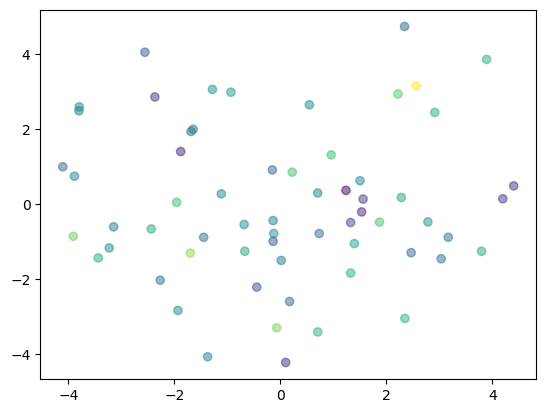

In [264]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=X_pca[:,2], alpha=0.5)

### Ergebnisse / Beobachtungen
- Daten scheinen recht gleichmäßig verteilt zu sein
- Keine unmittelbaren Cluster o. ä. erkennbar

## Kernel-PCA

- Sollte prinzipiell etwas bessere Ergebnisse als "Standard"-PCA liefern, da Features der Daten vermutlich nicht linear miteinander zusammenhängen

- Allgemeine Hilfsfunktion zum Darstellen von mehreren Plots, die für die Parametersuche der folgenden Algorithmen genutzt wird

In [312]:
# Input:
#   - results:  Computation results as an array of tuples with the form ("<<plot title>>", [<<2-dimensional array]),
#               where the 2-dimensional array describes the x- & y-position of each data point
#   - figsize_columns: number of columns which are used to layout the plotted graphs. The number of rows is depending on the number of 'results' and the given 'figsize_columns'.
# Ouput: The plotted graphs which represent the given data from 'results'
import math

def display_reduction_results(results, figsize_columns):
    figsize_rows = math.ceil(len(results) / figsize_columns)
    fig, ax = plt.subplots(figsize_rows, figsize_columns, figsize=(15, 15))
    fig.tight_layout(pad=3)

    for i in range(len(results)):
        plt.subplot(figsize_rows, figsize_columns, i+1).set_title(results[i][0])
        
        if len(results[i][1][0]) <= 2:
            plt.subplot(figsize_rows, figsize_columns, i+1).scatter(results[i][1][:,0], results[i][1][:,1])
        else:
            plt.subplot(figsize_rows, figsize_columns, i+1).scatter(results[i][1][:,0], results[i][1][:,1], c=results[i][1][:,2])

- Erste Tests mit manuellem Ausprobieren...

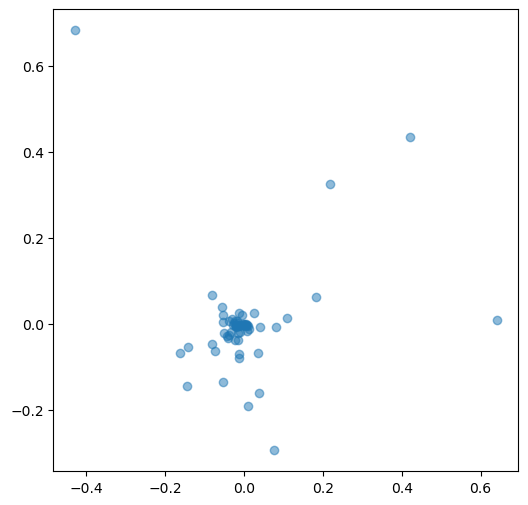

In [313]:
# Angabe der gewünschten Dimensionen
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=2)
X_kpca = kpca.fit_transform(data_scaled)
X_kpca

fix, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_kpca[:,0], X_kpca[:,1], alpha=0.5)

### Ergebnisse / Beobachtungen
- Bis auf wenige Ausreißer scheinen die Daten sehr nahe aneinander zugeordnet werden
- Skalierung scheint verhältnismäßig klein zu sein (auch wenn diese keine unmittelbare Aussage über die "Konzentration" der Daten zulässt)

- Gridsearch für Parameterwahl
- TODO: Klären, ob man GridSearch hierfür überhaupt benutzen kann/soll???

In [314]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

# def my_scorer(estimator, X, y=None):
#     X_reduced = estimator.transform(X)
#     X_preimage = estimator.inverse_transform(X_reduced)
#     return -1 * mean_squared_error(X, X_preimage)

param_grid = [{
        "n_components": [2, 3, 5, 10, 15, 25, 50],
        "gamma": np.linspace(0.03, 0.05, 10),
        "kernel": ["rbf", "sigmoid", "poly"]
    }]

X_kpca= KernelPCA(fit_inverse_transform=True, n_jobs=-1) 
grid_search = GridSearchCV(X_kpca, param_grid, cv=3, scoring='accuracy')
# grid_search = GridSearchCV(X_kpca, param_grid, cv=3, scoring={"MAE": make_scorer(mean_absolute_error, greater_is_better=False)},)
grid_search.fit(data_scaled)

grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.

(KernelPCA(fit_inverse_transform=True, gamma=0.03, kernel='rbf', n_components=2,
           n_jobs=-1),
 {'gamma': 0.03, 'kernel': 'rbf', 'n_components': 2},
 nan)

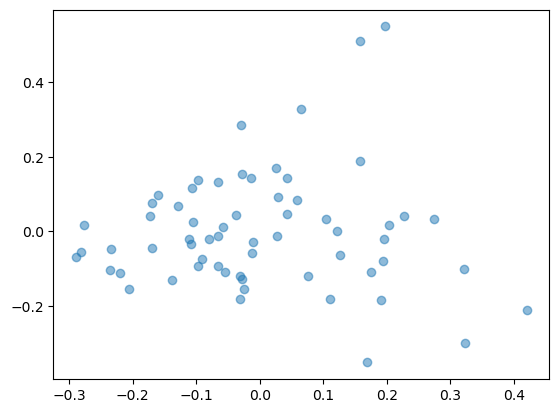

In [315]:
X_kpca = grid_search.best_estimator_.fit_transform(data_scaled)
plt.scatter(X_kpca[:,0], X_kpca[:,1], alpha=0.5)

- Ansatz
    - Anstelle einer Gridsearch manuell verschiedene Parameter-Kombinationen berechnen und die Ergebnisse als Plots ausgeben lassen
    - Aus Plots Schlüsse über Verwendbarkeit der Parameter-Kombinationen erschließen (Streuung der Daten, Korrelationen, sichtbare Cluster,...)
    - Problem: Bei Variation der Anzahl der Output-Features (n_components) ist der Vergleich nur schwierig möglich, da größere Anzahl von Features in 2D-Scatterplot nur schwierig darstellbar ist

In [316]:
n_components = [2, 3, 5, 10, 15]
gammas = [1, 2, 5, 10, 20]
kernels = ["rbf", "poly"]

kpca_results = []

for kernel in kernels:
    for gamma in gammas:
        for components in n_components:
            kpca = KernelPCA(n_components=components, gamma=gamma, kernel=kernel).fit_transform(data_scaled)
            parameter_string = "Comp: " + str(components) + ", Gamma: " + str(gamma) + ", Kernel: " + str(kernel)
            kpca_results.append((parameter_string, kpca))

In [317]:
len(kpca_results)

50

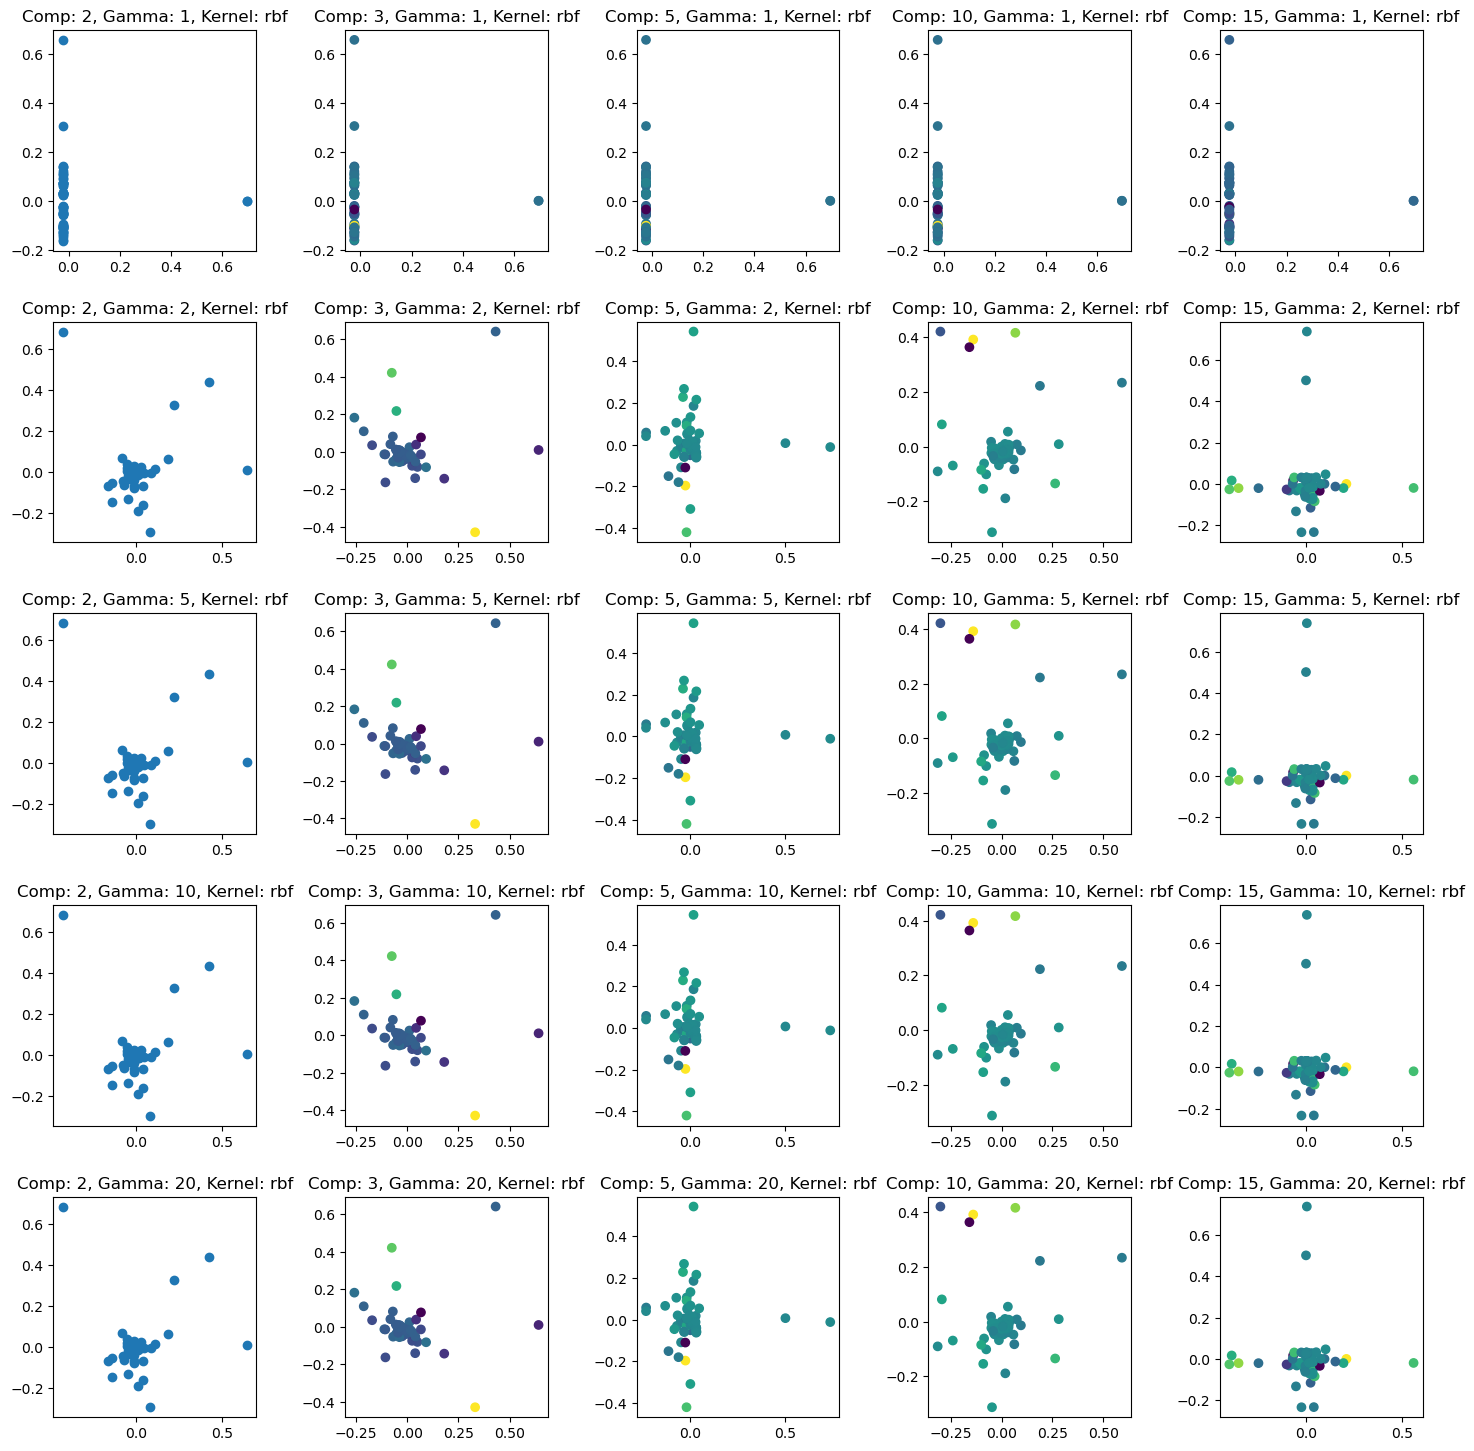

In [355]:
display_reduction_results(kpca_results[:25], 5)

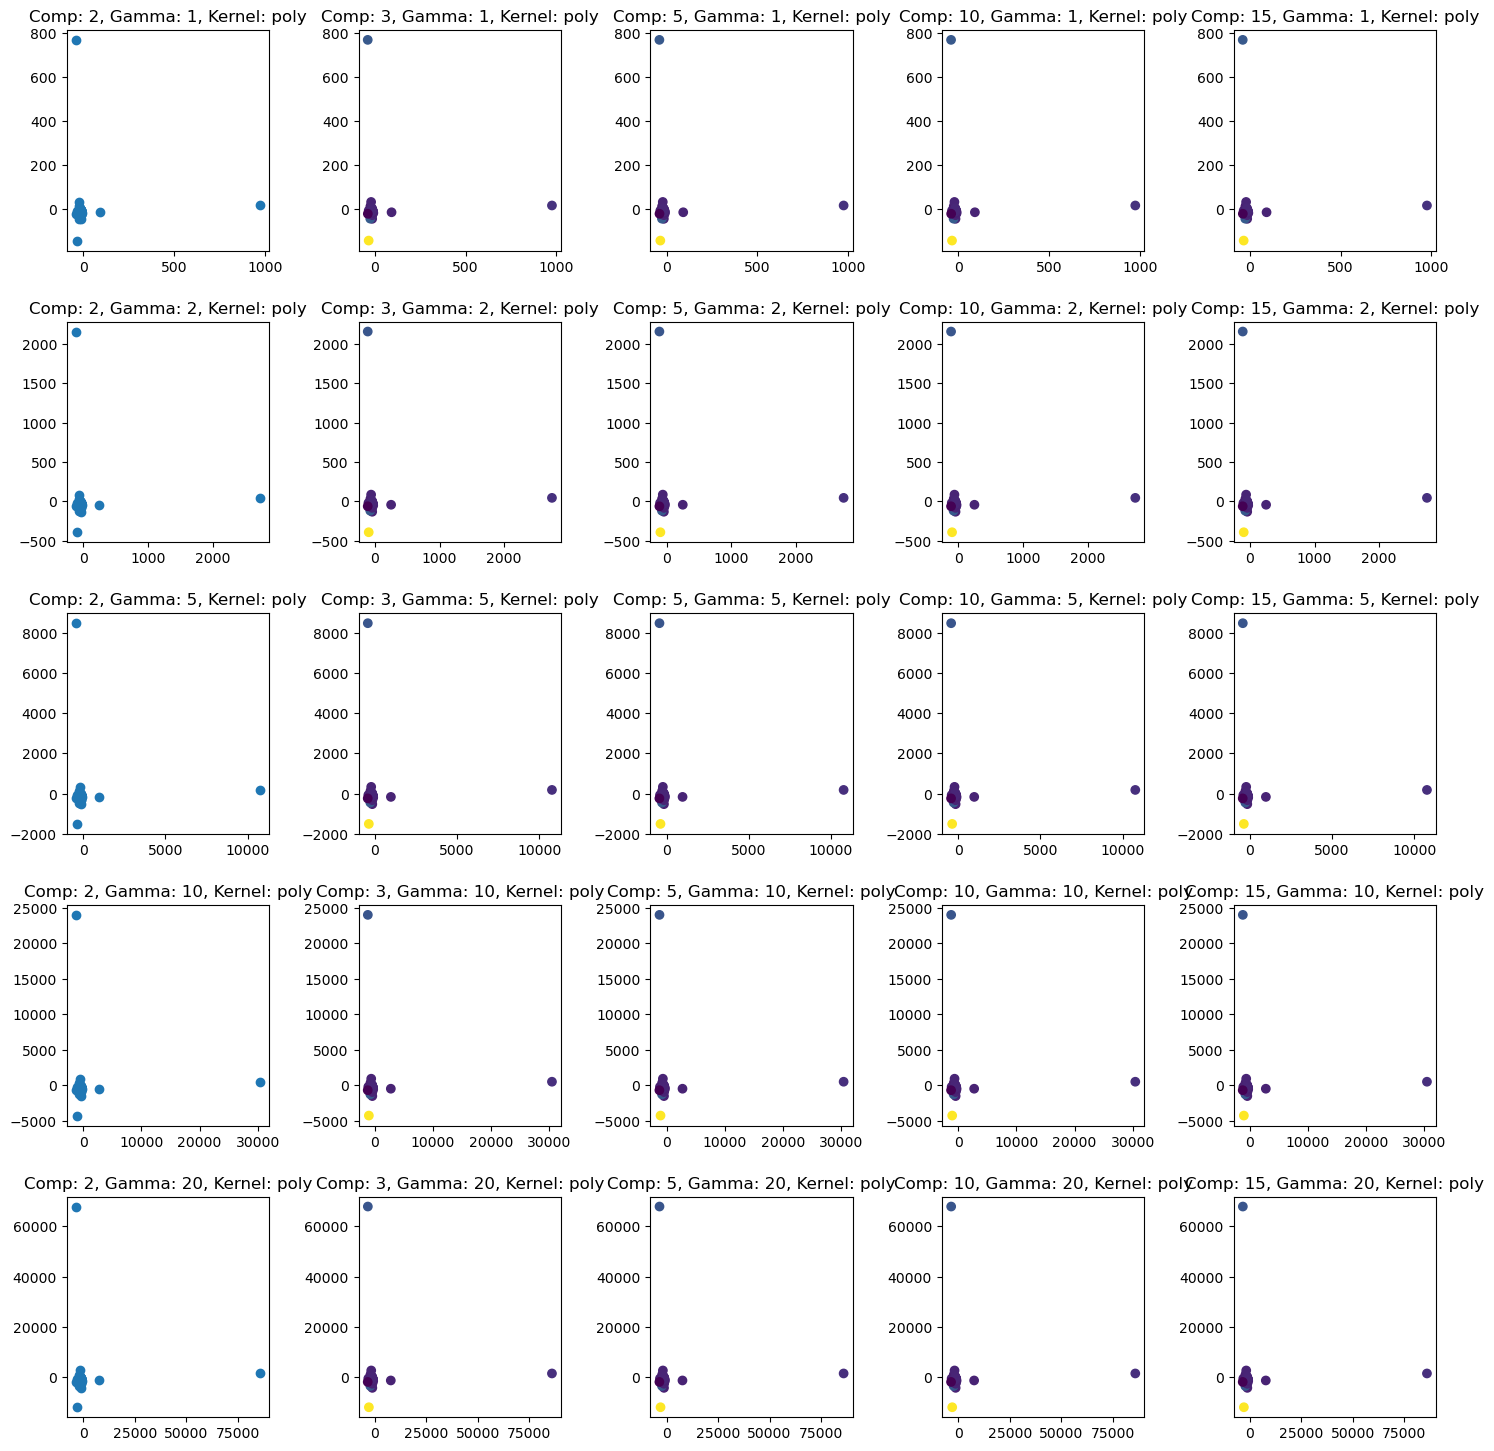

In [318]:
display_reduction_results(kpca_results[25:], 5)

### Ergebnisse / Beobachtungen
- Gamma-Wert 1 für den Kernel "rbf" scheint Daten in einer Achse immer auf denselben Wert zu setzen. Womöglich unterscheiden sich die Daten in einer höheren Dimension, das ist über diese Auswertungsmethode aber nur schwierig sichtbar
- In so gut wie allen Graphen sind Ausreißer zu erkennen; Insbesondere beim "poly"-Kernel, bei dem dadurch die Skalierung insofern ungünstig vergrößert werden muss, als dass die Verteilung der anderen Datenpunkte nicht mehr eindeutig zu erkennen ist. Es ist aber anhand der Graphen für den "rbf"-Kernel zu erkennen, dass die Daten insgesamt immer dazu tendieren, sich an einem Punkt zu häufen.

## t-SNE

- Sollte prinzipiell etwas bessere Ergebnisse als "Standard"-PCA liefern, da Features der Daten vermutlich nicht linear miteinander zusammenhängen
- Ist zwar grundsätzlich nicht sehr performant; Dies ist aufgrund der geringen Größe des Datensatzes aber vernachlässigbar

- Erste Tests mit manuellem Ausprobieren...

In [319]:
tsne = TSNE(perplexity=50, random_state=0)
X_tsne = tsne.fit_transform(data_scaled)
X_tsne

array([[-0.69405687,  1.1682488 ],
       [-0.79765165,  1.3321284 ],
       [-1.5896147 ,  1.2729965 ],
       [ 0.03760719,  1.5755262 ],
       [-0.15373576,  0.89934576],
       [-0.18905172,  1.3240123 ],
       [-1.115397  ,  1.981078  ],
       [-0.80233693,  1.1024377 ],
       [-0.60014987,  2.2048895 ],
       [-0.59602654,  1.8922955 ],
       [-0.5328714 ,  0.6370003 ],
       [ 0.22217715,  1.0243018 ],
       [-1.406957  ,  0.5879549 ],
       [-0.08245122,  0.9666505 ],
       [ 0.11553487,  0.38720867],
       [-0.1406774 ,  0.7312206 ],
       [-0.94014287,  1.8153208 ],
       [-0.89052296,  1.3215387 ],
       [-1.3239375 ,  1.2296374 ],
       [-0.14236447,  0.6849229 ],
       [-0.4872988 ,  1.2417269 ],
       [-0.7400696 ,  0.877329  ],
       [-0.3275008 ,  0.4531935 ],
       [-0.6250821 ,  0.6666584 ],
       [ 0.10629334,  1.3150983 ],
       [-0.5960993 ,  0.50846195],
       [-0.8816482 ,  1.2725722 ],
       [-0.80599105,  0.7807571 ],
       [-0.63249993,

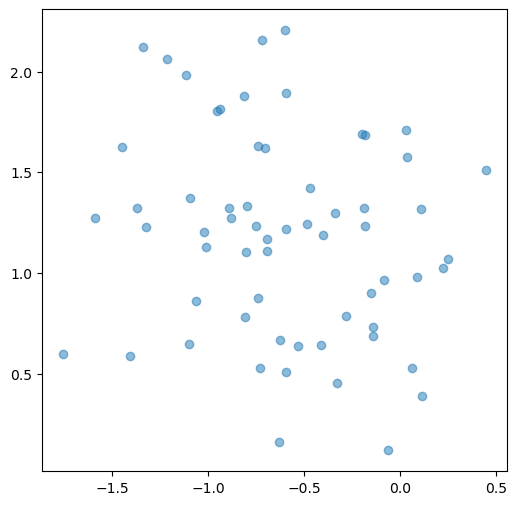

In [320]:
fix, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.5)

- Gridsearch für Parameterwahl
- TODO: Klären, ob man GridSearch hierfür überhaupt benutzen kann/soll???

In [321]:
param_grid = [{
        "n_components": [2, 3, 5, 10, 15, 25, 50],
        "perplexity": [5, 7, 10, 15, 20, 25, 30, 35, 40, 50],
        "early_exaggeration": [1, 2, 3, 5, 7, 10, 12, 15, 20]
    }]

tsne = TSNE(random_state=0)
grid_search = GridSearchCV(tsne, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(data_scaled)

grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
  File "C:\Users\Konstantin\AppData\Local\Temp\ipykernel_3364\1469466924.py", line 5, in my_scorer
    X_reduced = estimator.transform(X)
AttributeError: 'TSNE' object has no attribute 'transform'

  warnings.warn(
c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(

(TSNE(early_exaggeration=1, perplexity=5, random_state=0),
 {'early_exaggeration': 1, 'n_components': 2, 'perplexity': 5},
 nan)

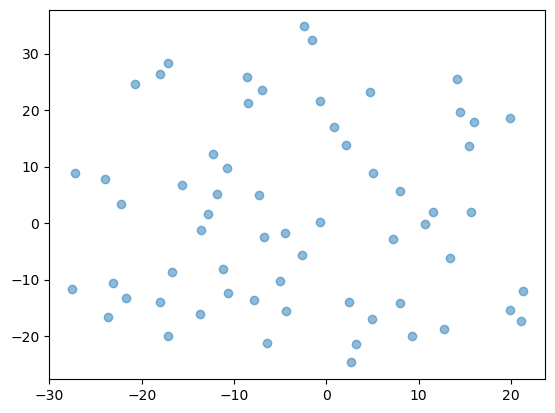

In [322]:
tsne = grid_search.best_estimator_.fit_transform(data_scaled)
plt.scatter(tsne[:,0], tsne[:,1], alpha=0.5)

- Ansatz
    - Anstelle einer Gridsearch manuell verschiedene Parameter-Kombinationen berechnen und die Ergebnisse als Plots ausgeben lassen
    - Aus Plots Schlüsse über Verwendbarkeit der Parameter-Kombinationen erschließen (Streuung der Daten, Korrelationen, sichtbare Cluster,...)

In [339]:
perplexities = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60]

tsne_results = []

for perplexity in perplexities:
    tsne = TSNE(perplexity=perplexity, random_state=0).fit_transform(data_scaled)
    parameter_string = "Perplexity: " + str(perplexity)
    tsne_results.append((parameter_string, tsne))

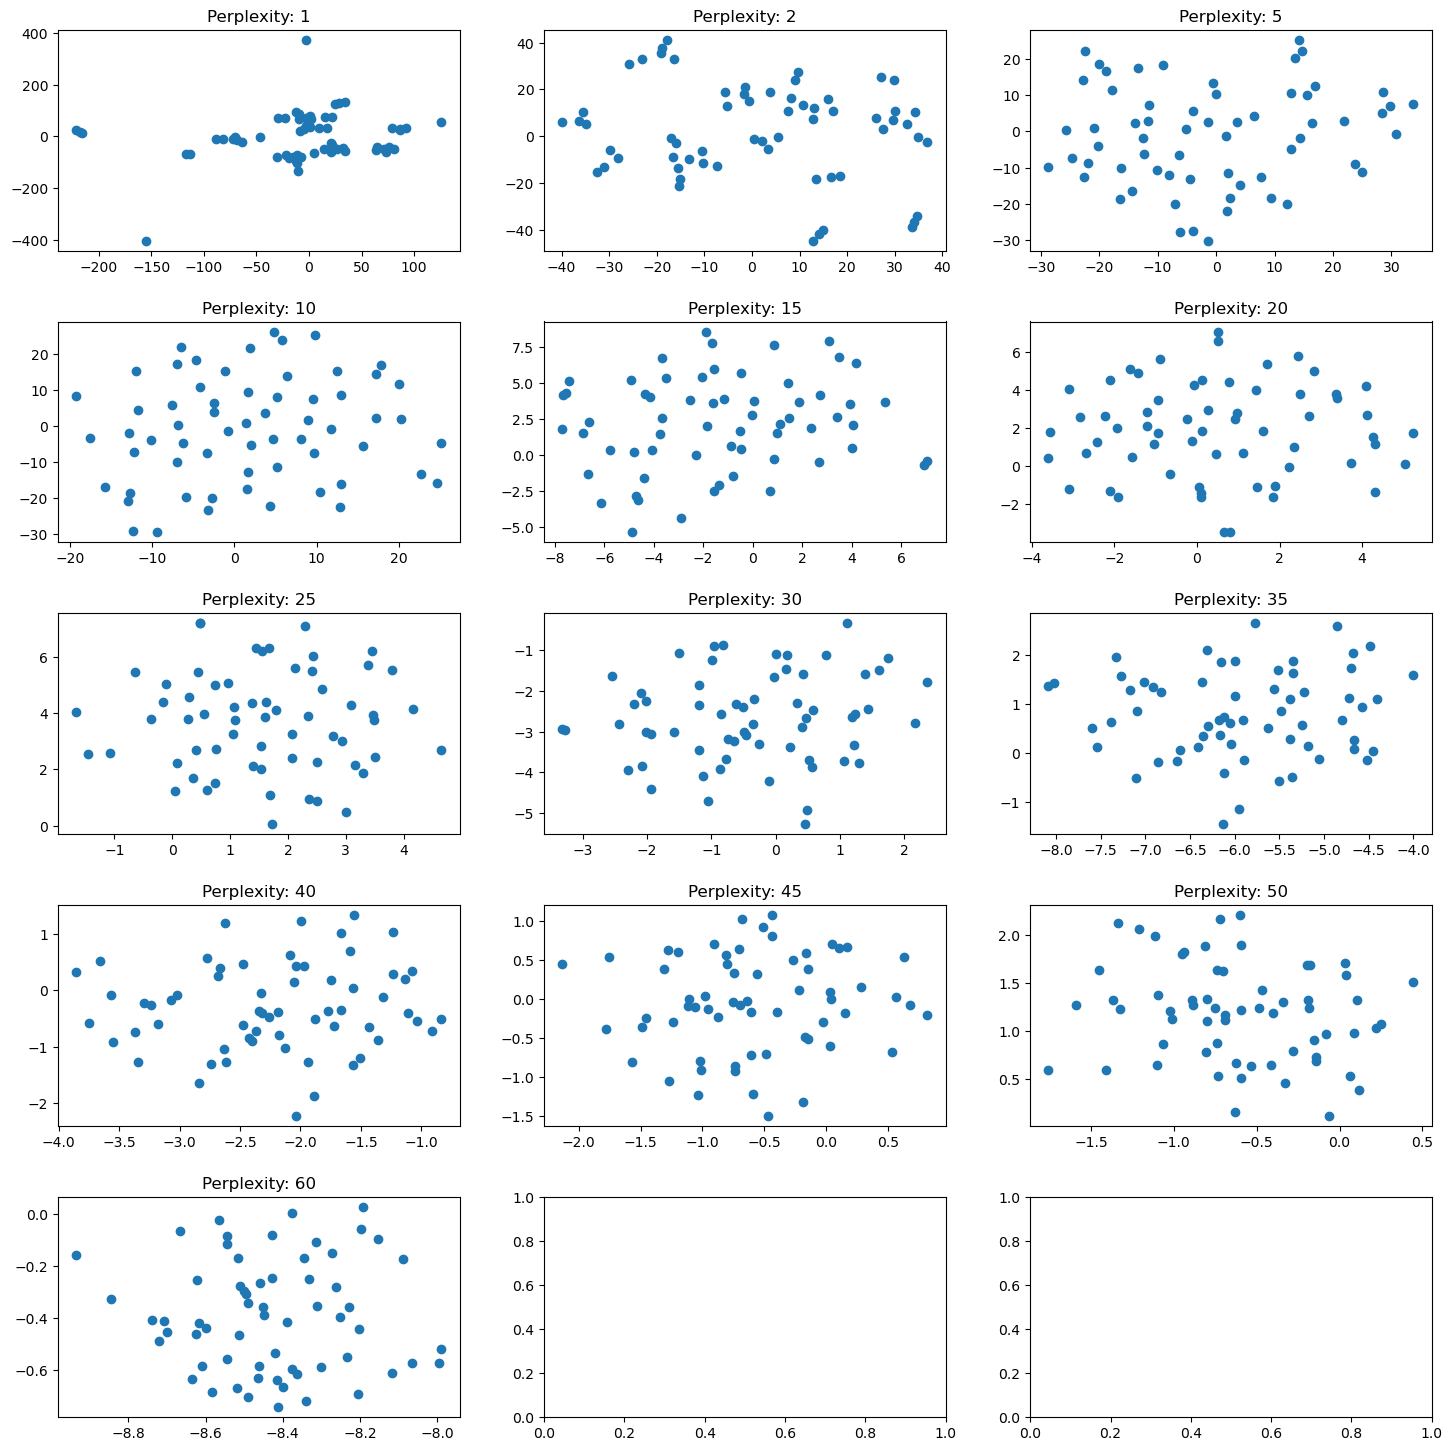

In [341]:
display_reduction_results(tsne_results, 3)

### Ergebnisse / Beobachtungen
- Insbesondere bei niedrigeren "Perplexity"-Werten sind schon auf den ersten Blick klare Cluster zu erkennen
- Wie bspw. in diesem [Online Artikel](https://distill.pub/2016/misread-tsne/) beschrieben, ergeben sich solche Cluster durch die starke Gewichtung lokaler Strukturen im Algorithmus und haben für die praktische Auswertung keine Bedeutung: "[...] those “clumps” aren’t meaningful. If you look back at previous examples, low perplexity values often lead to this kind of distribution. Recognizing these clumps as random noise is an important part of reading t-SNE plots. [...]"
- Laut der offiziellen [Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) sollte der "Perplexity"-Wert stattdessen zwischen 5 und 50 gewählt werden. Da beim Graphen des "Perplexity"-Werts 30 zumindest kleinere Strukturen erkennbar sind (und dieser Wert zufällig auch dem Default-Wert entspricht), wird im Folgenden die Dimensionsreduzierung von t-SNE mit einem "Perplexity"-Wert von 30 genutzt

In [376]:
data_original_reduced_tsne = TSNE(perplexity=30, random_state=0).fit_transform(data_scaled)
%store data_original_reduced_tsne

Stored 'data_original_reduced_tsne' (ndarray)


# Dimensionsreduzierung auf Themenbereiche

- Bei Korrelationsanalyse wurde deutlich, dass in den jeweiligen Datenpunkten am ehesten die Features (bzw. Antworten zu Fragen) korrelieren, die inhaltlich ähnlich Interessen prüfen. Diese Beobachtung passt auch zu der Intuition, dass Menschen sich grundsätzlich für gewisse Lebensbereiche interessieren, und Fragen zu demselben Lebensbereich im Allgemeinen ähnlich beantwortet werden. Beispiele:
    - Korrelation von "Wie sehr interessierst du dich für darstellende Künste wie Schauspiel, Tanz oder Gesang?" mit "Wie sehr interessierst du dich für bildende Kunst wie\nMalen, Zeichnen oder Fotografie?" -> 0.7
    - Korrelation von "Prokrastinierst du, wenn du lernen müsstest?" mit "Wie häufig machst du Abgaben auf den letzten Drücker?" -> 0.5
- Ausgehend von dieser Beobachtung wäre es naheliegend bzw. denkbar, die gestellten Fragen inhaltlich nach bestimmten Bereichen zu gruppieren
- Um die Werte für jeden Themenbereich zu berechnen, könnte (da alle Fragen gleich skaliert sind) theoretisch einfach (arithmetische) Mittelwerte genutzt werden
- Alternativer Ansatz: Algorithmen zur Dimensionsreduzierung der jeweiligen Features der Themenbereiche nutzen

## Vorbereitung der Daten

- Aufteilen der Features in die Themenbereiche "Demographie", "Kreativität", "Wissenschaft", "Soziales", "Studienverhalten" & "Persönlichkeit"

In [343]:
short_labels = ["alter", "geschlecht", "pseudonym", "funktion", "studiengang", "sportlichkeit", "lieblingssportart",
          "ernaehrung", "essengehen", "kochen", "feiern", "lieblingsessen", "musik", "lieblingsmusiker", "lesen", "schauspiel",
          "filme", "malen", "museumsbesuche", "videospiele", "social_media", "technologie", "astronomie", "naturwissenschaften",
          "freiwilligenarbeit", "soziales", "introvertiert", "fomo", "spontan", "verwirrt", "gluecklich", "geduldig", "streitlustig",
          "abenteuerlustig", "studienzweifel", "studium_zufriedenheit", "akademische_laufbahn", "lerngruppe", "prokrastinieren",
          "letzter_druecker", "neue_lebensmittel", "natur", "reisen", "handwerk", "sprachnachrichten", "geld",]

In [344]:
# Ursprüngliche Kategorien
# cat_demography = ["alter", "geschlecht", "pseudonym", "funktion", "studiengang"]

# Nach entfernen nicht-numerischer Werte
cat_demography = ("Demographie", ["alter"])

cat_sport = ("Sport", ["sportlichkeit", "ernaehrung", "essengehen", "kochen", "feiern",
 "sportarten_Basketball",
 "sportarten_Bouldern/Klettern",
 "sportarten_Football",
 "sportarten_Fußball",
 "sportarten_Handball",
 "sportarten_Hockey",
 "sportarten_Kampfsport",
 "sportarten_Leichtathletik",
 "sportarten_Reiten",
 "sportarten_Rennrad/Mountainbike",
 "sportarten_Schwimmen",
 "sportarten_Tanzen",
 "sportarten_Tennis",
 "sportarten_Volleyball",
 "sportarten_Wassersport",
 "sportarten_Wintersport",
 "sportarten_Yoga"])

cat_creativity =    ("Kreativität", ["musik", "lesen", "schauspiel", "filme", "malen", "museumsbesuche"])
cat_science =       ("Wissenschaft", ["videospiele", "social_media", "technologie", "astronomie", "naturwissenschaften"])
cat_social =        ("Soziales", ["freiwilligenarbeit", "soziales", "introvertiert", "fomo", "spontan", "verwirrt", "gluecklich", "geduldig", "streitlustig", "abenteuerlustig"])
cat_study =         ("Studienverhalten", [ "studienzweifel", "studium_zufriedenheit", "akademische_laufbahn", "lerngruppe", "prokrastinieren", "letzter_druecker"])
cat_personality =   ("Persönlichkeit", ["neue_lebensmittel", "natur", "reisen", "handwerk", "sprachnachrichten", "geld"])

all_categories = [cat_demography, cat_sport, cat_creativity, cat_science, cat_social, cat_study, cat_personality]
all_categories

[('Demographie', ['alter']),
 ('Sport',
  ['sportlichkeit',
   'ernaehrung',
   'essengehen',
   'kochen',
   'feiern',
   'sportarten_Basketball',
   'sportarten_Bouldern/Klettern',
   'sportarten_Football',
   'sportarten_Fußball',
   'sportarten_Handball',
   'sportarten_Hockey',
   'sportarten_Kampfsport',
   'sportarten_Leichtathletik',
   'sportarten_Reiten',
   'sportarten_Rennrad/Mountainbike',
   'sportarten_Schwimmen',
   'sportarten_Tanzen',
   'sportarten_Tennis',
   'sportarten_Volleyball',
   'sportarten_Wassersport',
   'sportarten_Wintersport',
   'sportarten_Yoga']),
 ('Kreativität',
  ['musik', 'lesen', 'schauspiel', 'filme', 'malen', 'museumsbesuche']),
 ('Wissenschaft',
  ['videospiele',
   'social_media',
   'technologie',
   'astronomie',
   'naturwissenschaften']),
 ('Soziales',
  ['freiwilligenarbeit',
   'soziales',
   'introvertiert',
   'fomo',
   'spontan',
   'verwirrt',
   'gluecklich',
   'geduldig',
   'streitlustig',
   'abenteuerlustig']),
 ('Studienve

In [345]:
# Helper-method to perform dimensionality reduction for given data and reduction model on predefined categories
# Input:
#   - data: DataFrame to be reduced
#   - model: Model which is used to perform reduction; Has to support the .fit_transform()-function
# Output: DataFrame, which used the given model to reduce the data to the predefined categories

def compute_categories(data, model):
    data_reduced = pd.DataFrame(columns=[category[0] for category in all_categories])
    for category in all_categories:
        model_trained = model.fit_transform(data[[columns[x] for x in category[1]]])
        data_reduced[category[0]] = model_trained[:,0]
    return data_reduced

## PCA

- Mithilfe von PCA für jeden Datenpunkt die Features der jeweiligen Themenbereich berechnen und in einem neuen Dataframe zusammenfassen
- Die zu berechnende Dimension pro Themenbereich ist offensichtlich 1, deshalb wird der Parameter "n_components" jeweils auf 1 gesetzt

In [346]:
pca = PCA(n_components=1)

data_reduced_PCA = compute_categories(data_scaled, pca)
data_reduced_PCA

,Demographie,Sport,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,0.555073,-1.045241,-0.063565,-1.481797,0.405950,-1.635010,0.730060
1,0.105210,-0.775327,-0.850067,1.617876,-0.517746,-1.494638,-0.224172
2,-0.344653,2.200932,-1.671769,-0.669291,-1.797866,-1.035561,-1.429170
3,-0.569585,-1.387377,1.363657,0.105325,0.121731,-0.903822,1.204482
4,-0.344653,-0.566647,0.823353,-2.294303,-0.164162,2.018491,-0.347283
...,...,...,...,...,...,...,...
57,0.105210,2.237052,-3.023933,-1.345619,-0.158858,-2.657732,0.060967
58,-0.794517,0.332908,3.230977,-1.985446,0.103726,0.038180,0.662259
59,-0.119722,-0.531107,-0.778620,-1.918051,-0.498246,1.668469,2.008838
60,1.229868,0.838900,-3.183976,1.385794,-0.388389,-1.960236,1.699726


- Ausgabe der Ergebnisse als Pairplot, in dem alle Themenbereiche gegeneinander aufgespannt werden

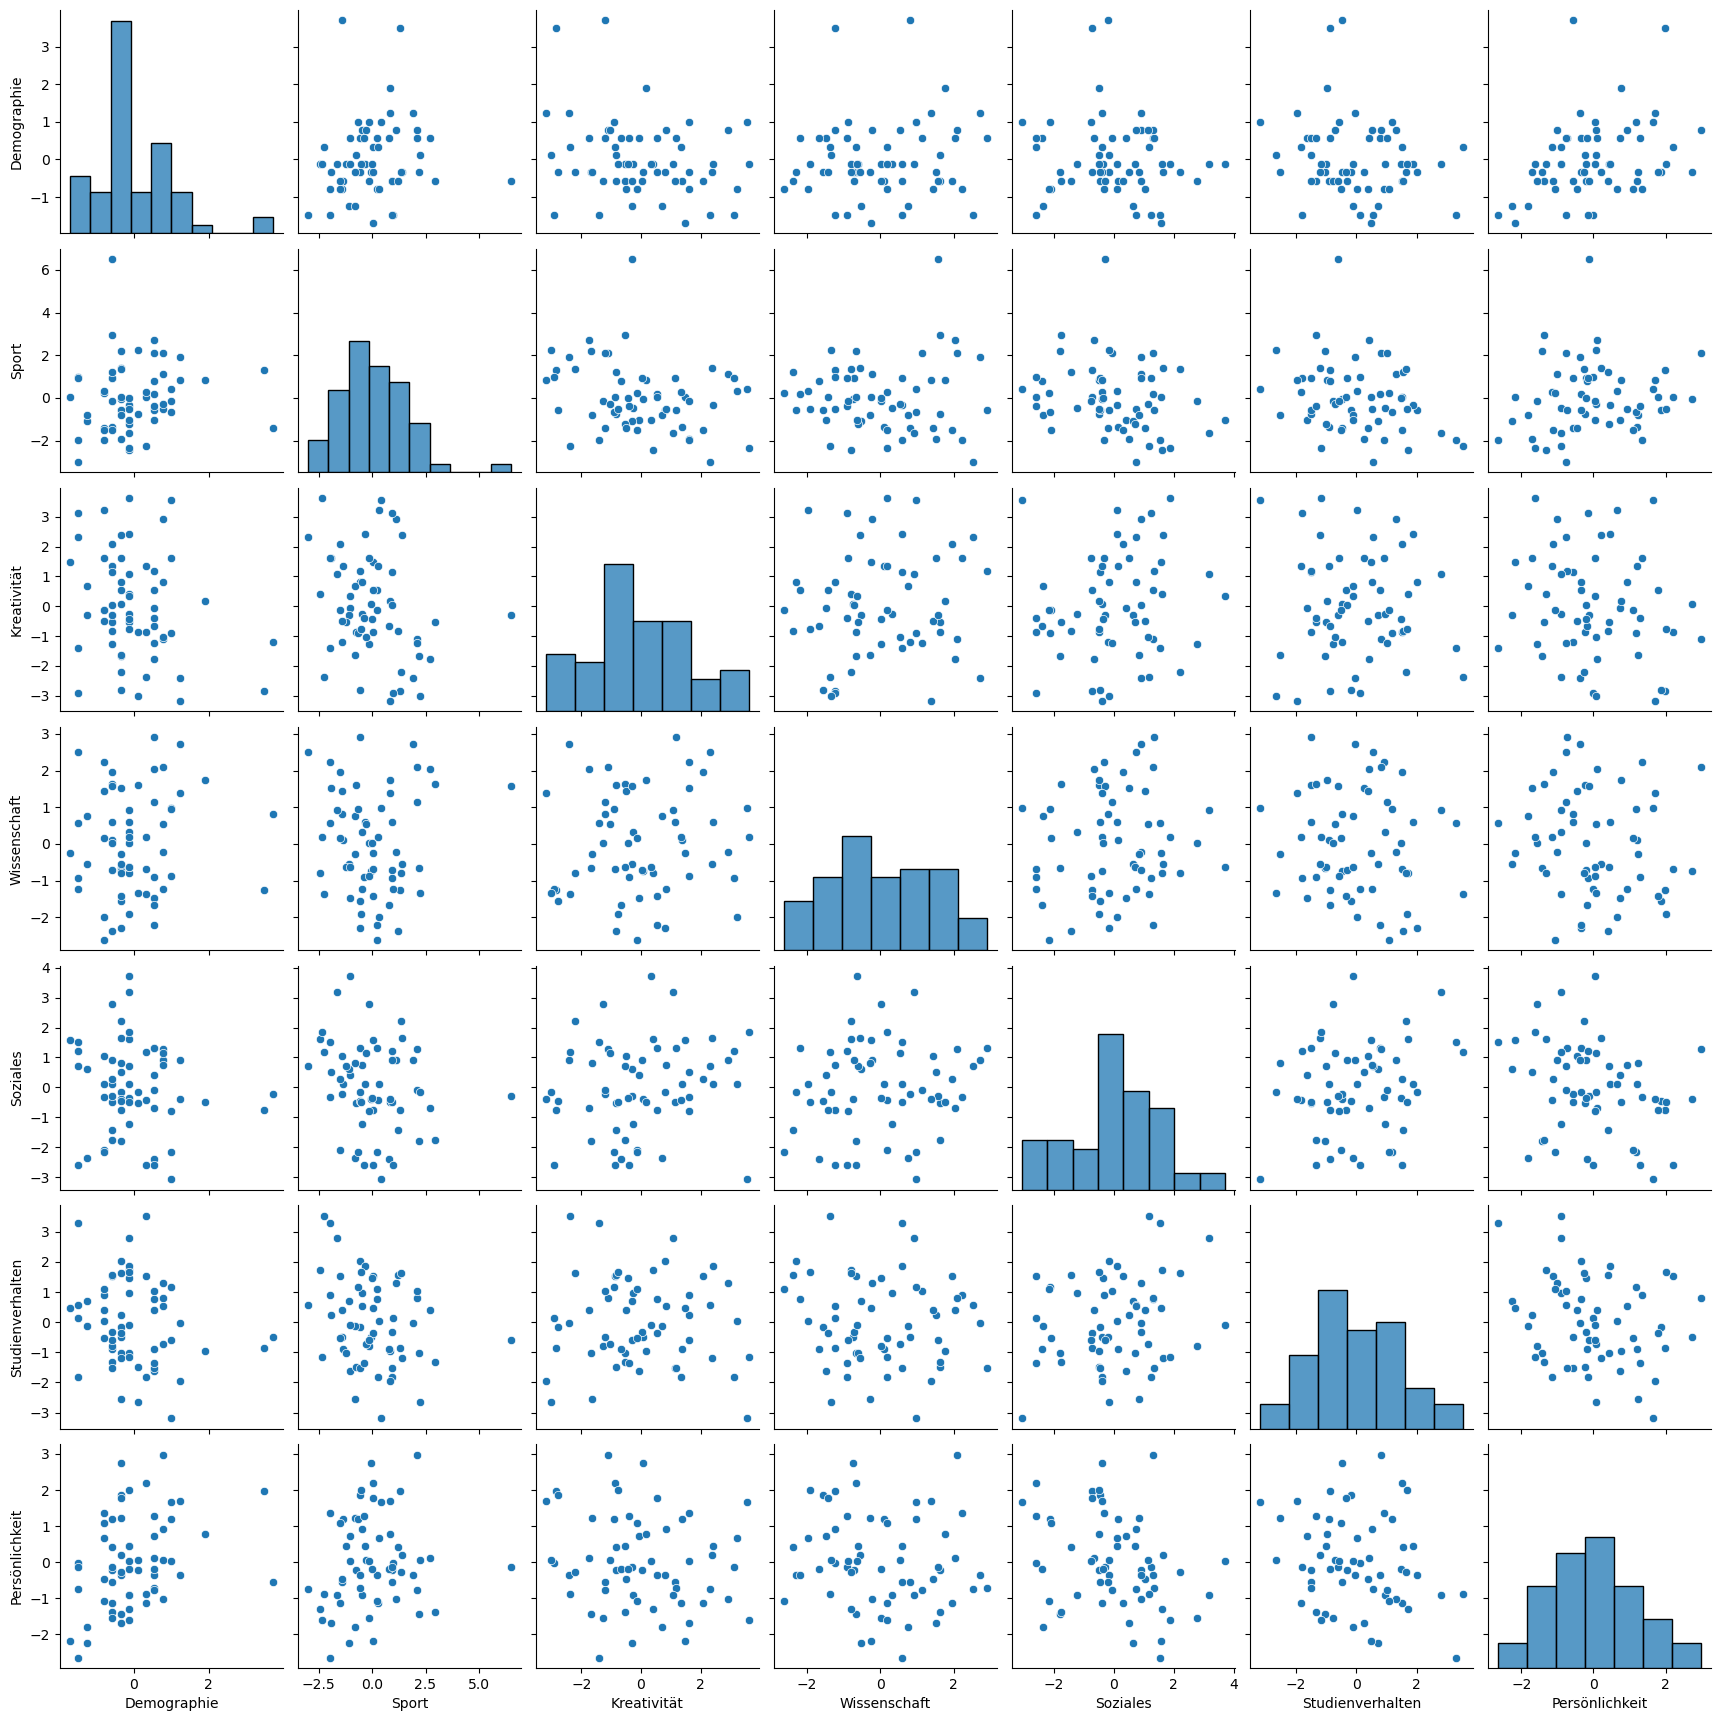

In [348]:
sb.pairplot(data_reduced_PCA)

### Ergebnisse / Beobachtungen
- 

## Kernel PCA

- Mithilfe von Kernel-PCA für jeden Datenpunkt die Features der jeweiligen Themenbereich berechnen und in einem neuen Dataframe zusammenfassen
- Die zu berechnende Dimension pro Themenbereich ist offensichtlich 1, deshalb wird der Parameter "n_components" jeweils auf 1 gesetzt
- Problem: Die Konfiguration der weiteren Parameter ist nicht intuitiv ersichtlich. Da als Ergebnis zudem sieben Dimensionen (bzw. Features) erzeugt werden, ist ein Vergleich der Ergebnisse mit verschiedenen Parametern nicht möglich.
- Stattdessen wurde auf Basis der Erkenntnisse aus der obigen Untersuchung und manuellem Ausprobieren die folgende Parameter-Konfiguration gewählt...

In [370]:
kpca = KernelPCA(n_components=1, kernel="rbf", gamma=1)

data_reduced_kPCA = compute_categories(data_scaled, kpca)
data_reduced_kPCA

,Demographie,Sport,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,0.649521,-0.029008,-0.072323,0.354519,-0.036199,-0.065395,0.008775
1,0.178282,-0.029008,-0.026302,-0.312151,-0.035542,0.680684,0.609035
2,-0.339394,-0.029008,-0.020185,0.394759,-0.035668,-0.023958,-0.008565
3,-0.503842,-0.029008,0.005427,0.013175,-0.037286,0.428626,0.026250
4,-0.339394,0.045535,-0.001480,-0.003015,-0.036315,-0.051439,0.008487
...,...,...,...,...,...,...,...
57,0.178282,-0.029008,-0.152107,0.038677,-0.035960,0.003806,-0.432017
58,-0.577100,-0.029185,-0.002770,-0.039669,-0.035643,-0.027941,0.040524
59,-0.099483,-0.029008,-0.067518,-0.023556,-0.035577,-0.026121,0.009827
60,0.720762,-0.029008,-0.175349,-0.085935,-0.037522,0.010576,0.052436


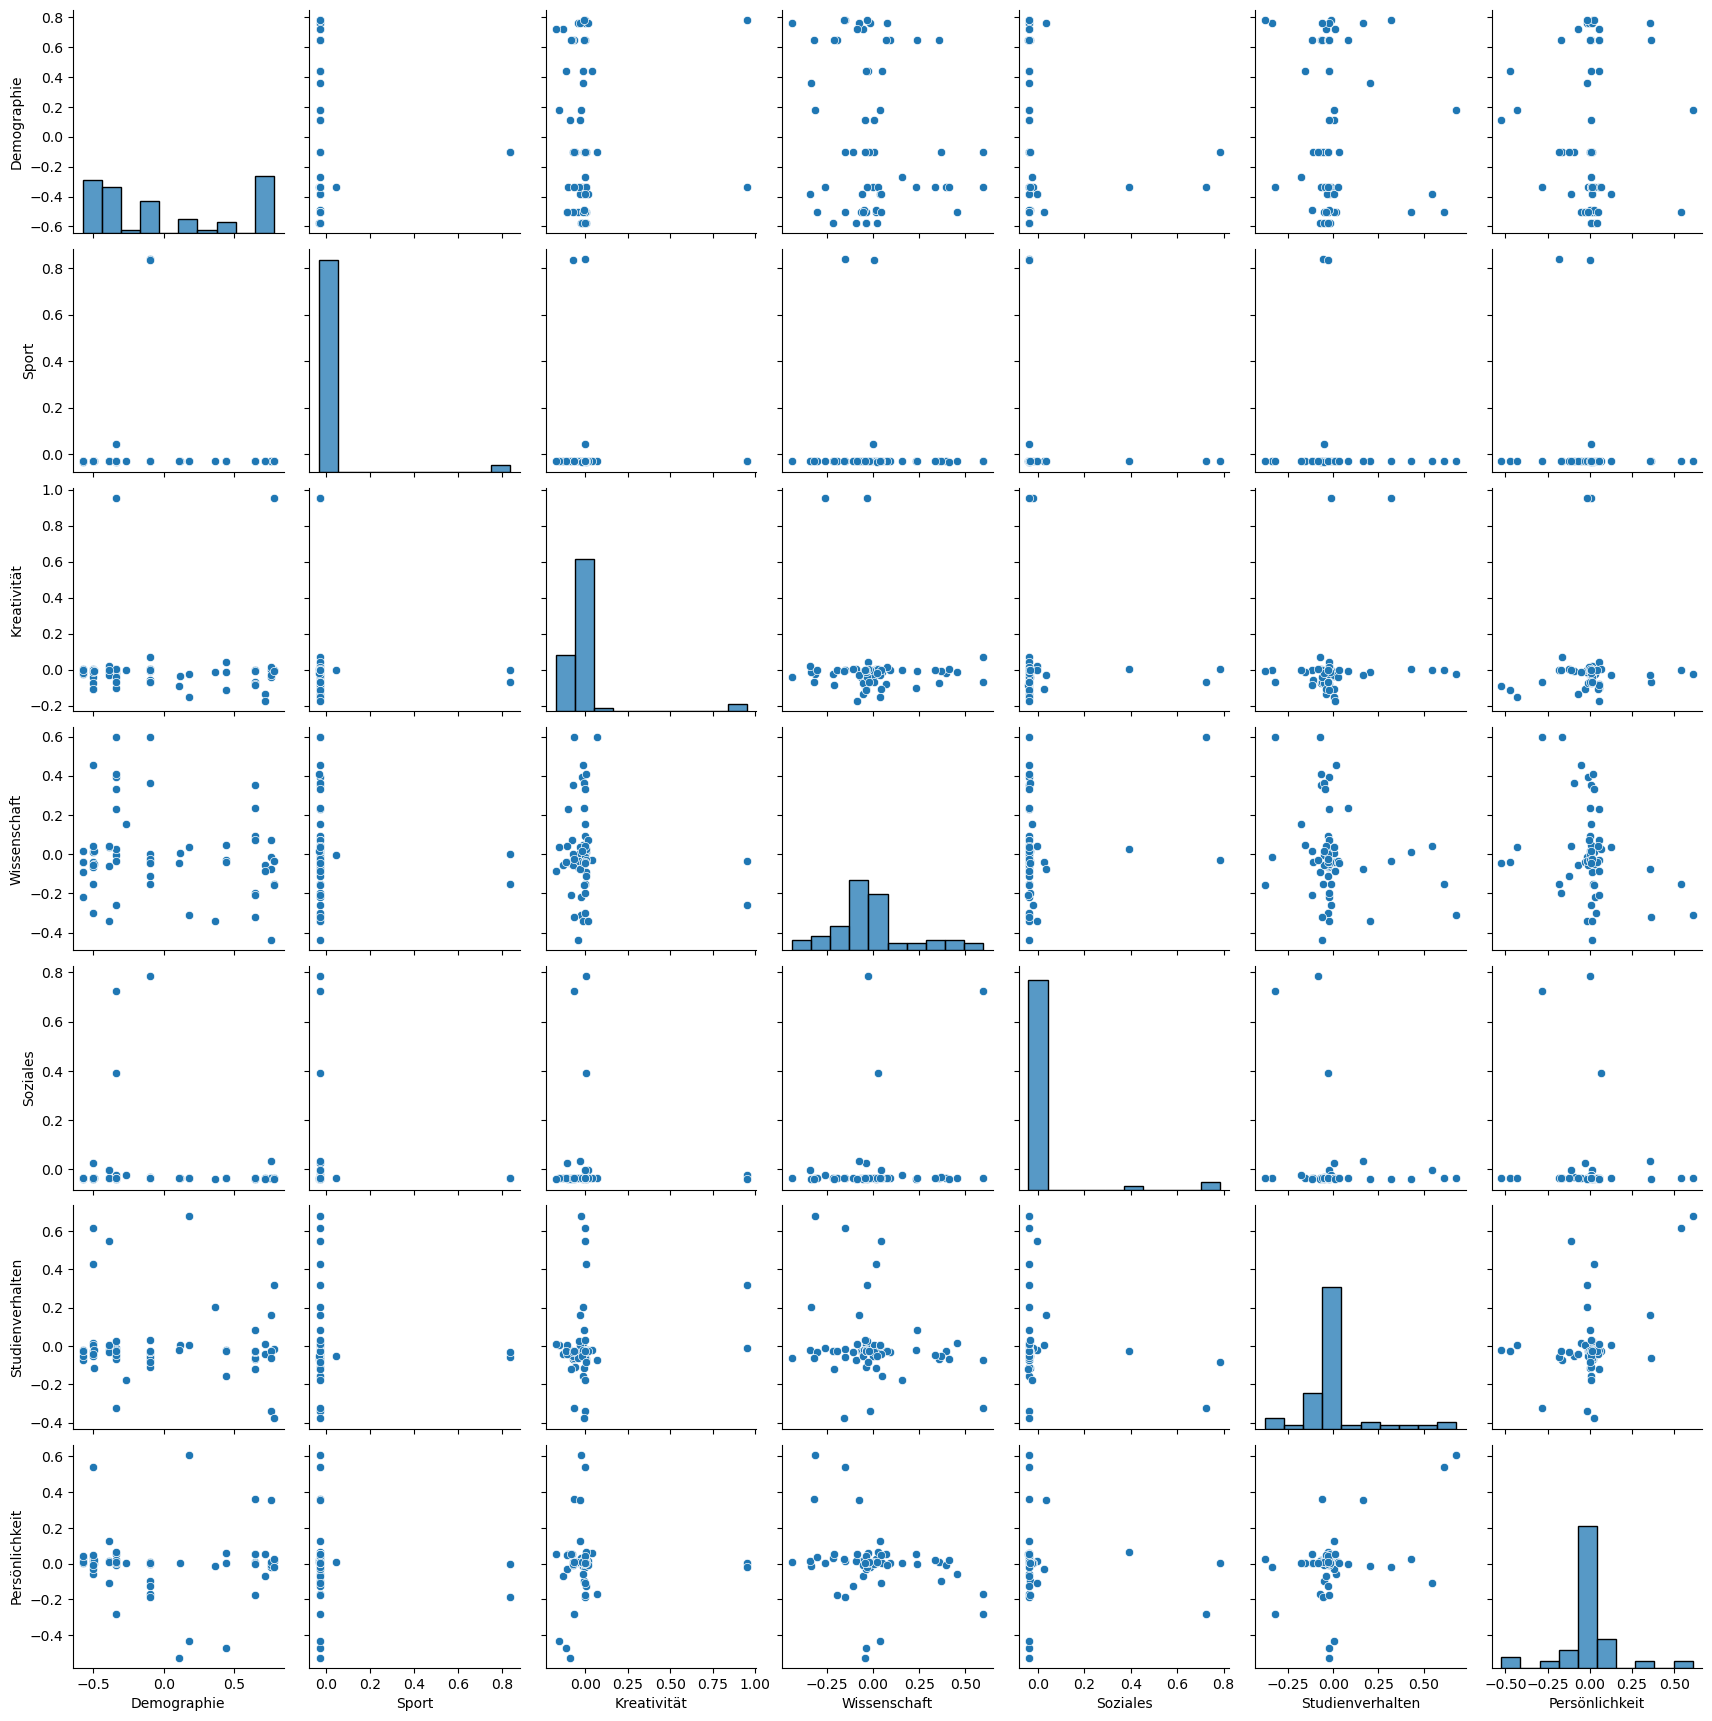

In [371]:
sb.pairplot(data_reduced_kPCA, diag_kws = {"bins": 10})

### Ergebnisse / Beobachtungen
- Ähnlich wie bei der Dimensionsreduzierung der Ursprungsdaten mit Kernel-PCA ergeben sich für viele Feature-Kombinationen "linienförmige" Graphen und solche, bei denen die Daten verhältnismäßig nahe beieinander liegen
- ...

## t-SNE

- Mithilfe von t-SNE für jeden Datenpunkt die Features der jeweiligen Themenbereich berechnen und in einem neuen Dataframe zusammenfassen
- Die zu berechnende Dimension pro Themenbereich ist offensichtlich 1, deshalb wird der Parameter "n_components" jeweils auf 1 gesetzt
- Problem: Die Konfiguration der "Perplexity" ist nicht intuitiv ersichtlich. Da als Ergebnis zudem sieben Dimensionen (bzw. Features) erzeugt werden, ist ein Vergleich der Ergebnisse mit verschiedenen Werten nicht (nur schwierig) möglich.
- Stattdessen wurde auf Basis der Erkenntnisse aus der obigen Untersuchung und manuellem Ausprobieren die folgende Parameter-Konfiguration gewählt...

In [377]:
tsne = TSNE(n_components=1, perplexity=20, random_state=0)

data_topics_reduced_tsne = compute_categories(data_scaled, tsne)
data_topics_reduced_tsne

,Demographie,Sport,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,-476.606110,-6.862202,-0.913240,-4.797374,-4.300110,2.095050,-1.299672
1,9.004629,-7.313879,0.911132,0.304318,-2.588881,0.904984,-2.627713
2,583.944824,-9.980322,0.833324,-4.104627,0.259089,2.656161,-5.143603
3,381.668213,-8.040555,-3.820459,-1.907142,-1.323033,0.678993,-2.146882
4,583.944824,-8.218645,-3.431772,-4.840188,-3.092754,-3.187543,-5.590951
...,...,...,...,...,...,...,...
57,9.004629,-3.983061,0.206428,-4.424846,-1.122722,1.378208,-3.918919
58,219.110443,-7.607538,3.073749,-6.528090,-4.838931,-0.370491,-2.918620
59,-127.193497,-6.766519,-1.414884,-5.347167,-2.591159,4.984735,-1.515456
60,-612.033569,-9.530220,0.093959,1.378906,-2.966359,2.118678,-2.019098


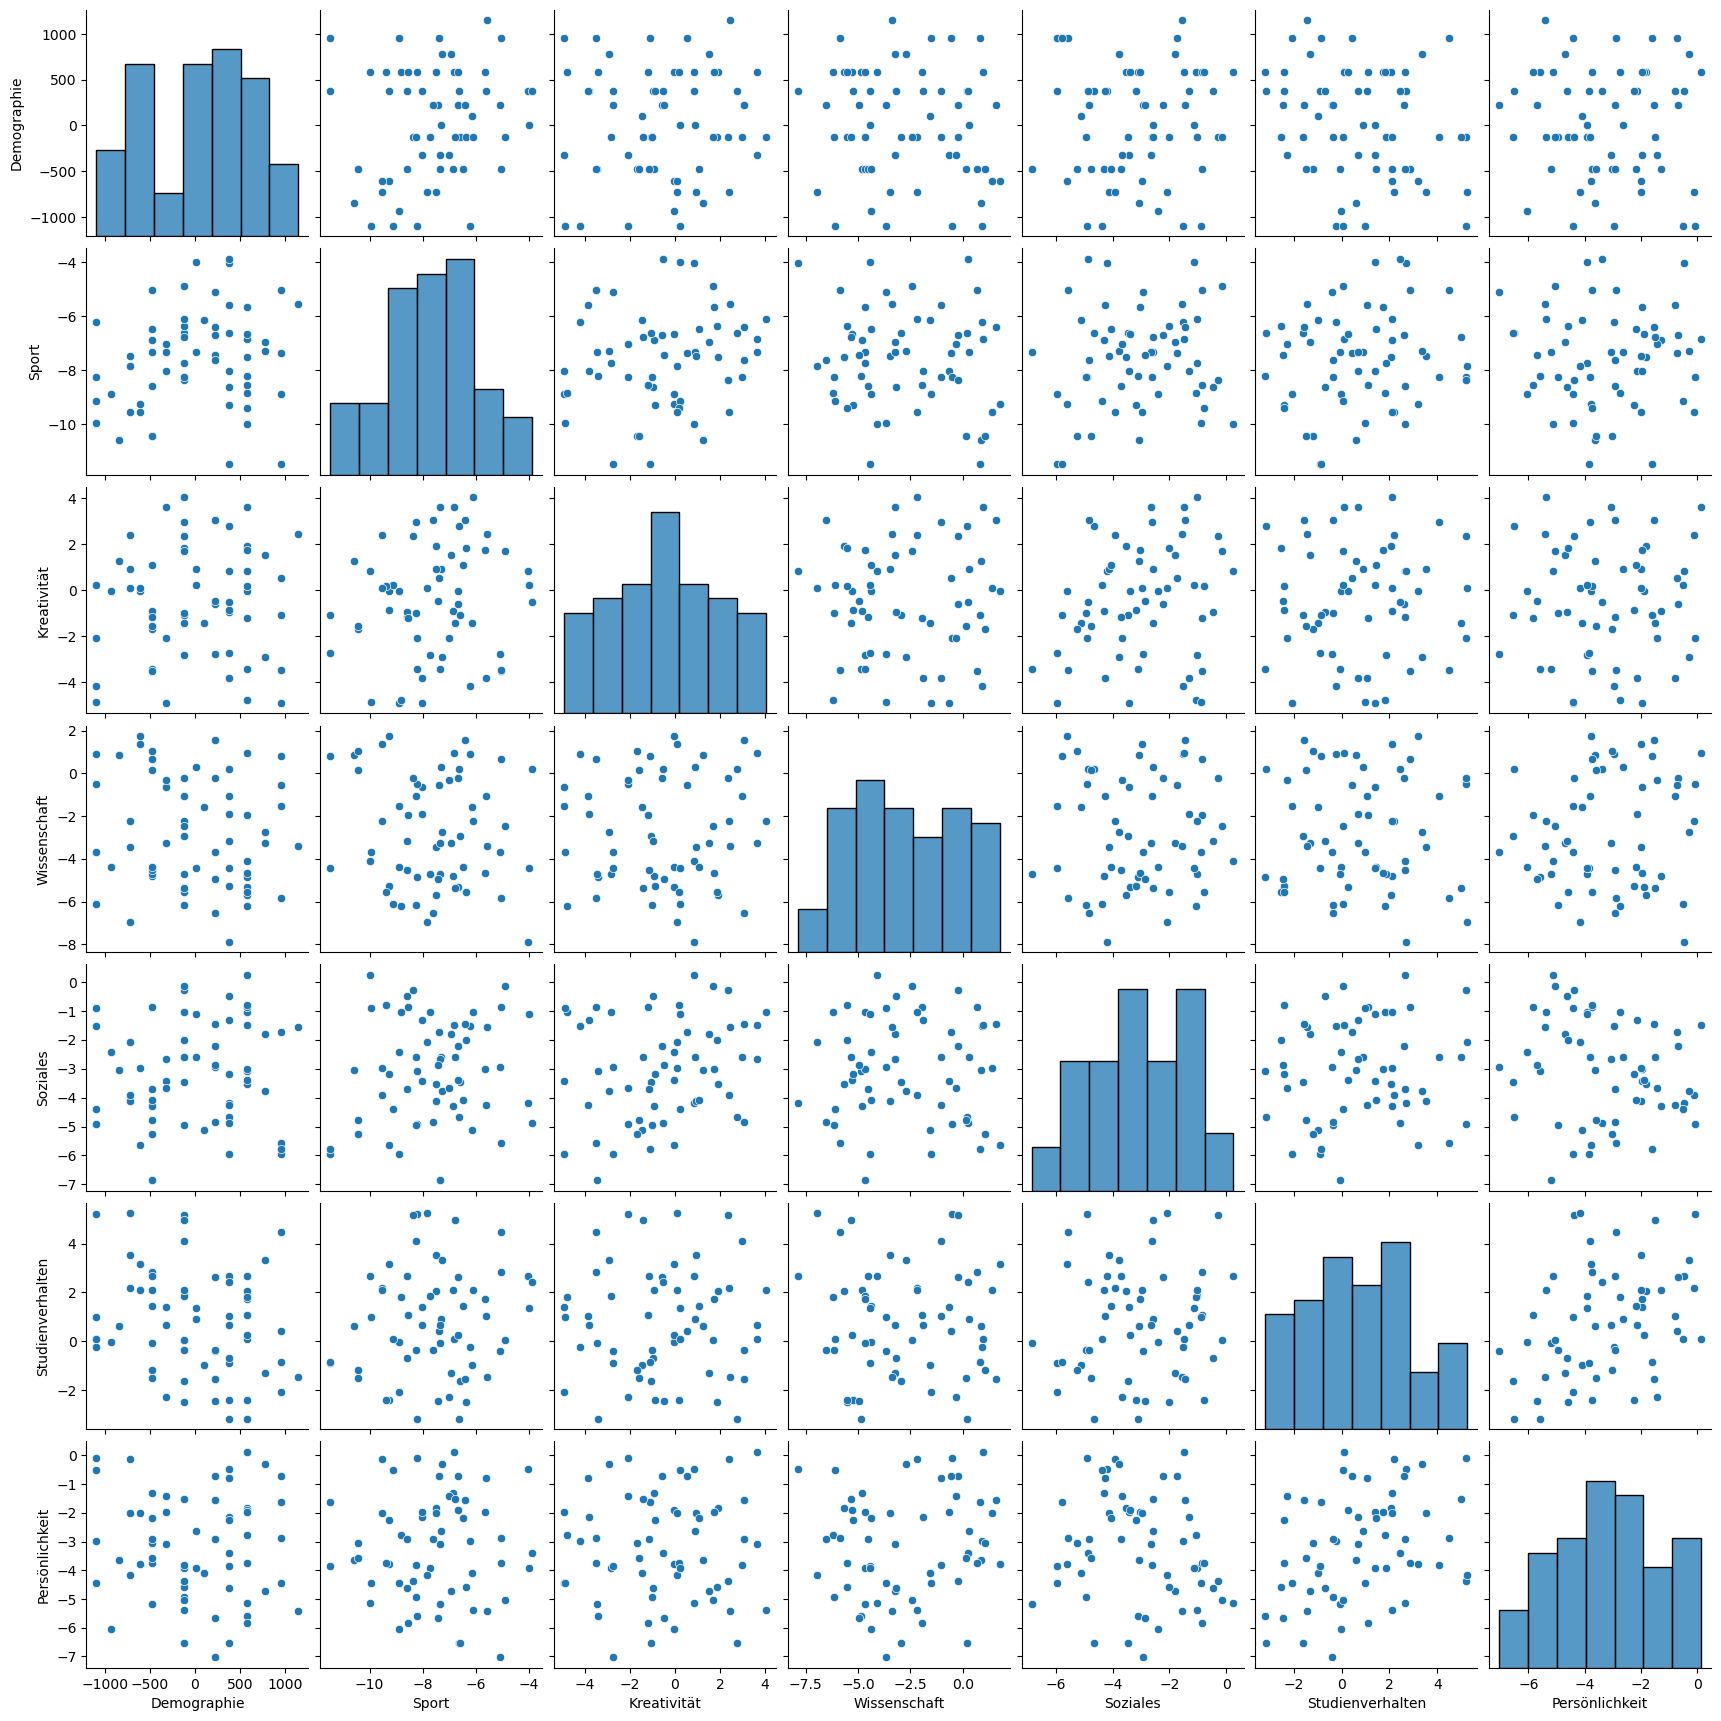

In [375]:
sb.pairplot(data_topics_reduced_tsne)

### Ergebnisse / Beobachtungen
- Ähnlich zur Dimensionsreduzierung sind in einigen der Graphen kleinere Strukturen zu erkennen, die möglicherweise ein Clustering ermöglichen
- Daher wird auch hier die t-SNE Variante für das weitere Vorgehen genutzt

In [378]:
%store data_topics_reduced_tsne

Stored 'data_topics_reduced_tsne' (DataFrame)
